# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']

In [7]:
df = pd.read_csv('data/yearly_tick_data/tab_2019.csv')
#df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,tick_avg,spread_avg,tick_sd,sema,lema,sema_diff,lema_diff,diff,avg_gain,avg_loss,...,sma_diff,max_tick,min_tick,max_gap,min_gap,ema_diff,small_sema_slope,long_sema_slope,slope_diff,direction
0,1.14666,0.00007,0.00003,1.14664,1.14658,0.00001,0.00003,-0.00001,0.00005,0.00003,...,0.00012,1.14667,1.14658,0.00001,-0.00008,0.00006,70.61279,77.80651,-7.19371,same
1,1.14671,0.00006,0.00005,1.14667,1.14661,0.00002,0.00003,0.00005,0.00005,0.00003,...,0.00010,1.14671,1.14658,0.00000,-0.00013,0.00006,66.98876,78.39118,-11.40241,same
2,1.14668,0.00006,0.00002,1.14668,1.14664,0.00001,0.00003,-0.00003,0.00005,0.00003,...,0.00007,1.14671,1.14662,0.00003,-0.00005,0.00004,61.43258,76.35751,-14.92494,same
3,1.14660,0.00005,0.00002,1.14665,1.14664,-0.00003,-0.00000,-0.00008,0.00005,0.00003,...,0.00003,1.14671,1.14660,0.00011,0.00000,0.00001,34.36016,71.15660,-36.79644,same
4,1.14650,0.00005,0.00005,1.14659,1.14661,-0.00006,-0.00003,-0.00010,0.00005,0.00004,...,0.00000,1.14671,1.14650,0.00021,0.00000,-0.00002,-51.53254,58.29498,-109.82752,decrease


In [8]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df, apply_smote = False)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 97275
--------------------------
same        78294
decrease     9760
increase     9221
Name: direction, dtype: int64
--------------------------
same        0.804873
decrease    0.100334
increase    0.094793
Name: direction, dtype: float64


['data/model/y_map.pkl']

## Neural Network

### Network building

In [9]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [10]:
model = Sequential([
    Dense(units = 2048, activation='relu', input_shape=(len(train_x[0]),)),
    Dense(units = 1024, activation='relu',),
    Dense(units = 512, activation='relu'),    
    Dense(units = 256, activation='relu'),
    Dense(units = 128, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(    
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01),
    metrics=CategoricalAccuracy())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              53248     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 2,840,835
Trainable params: 2,840,835
Non-trainable params: 0
______________________________________________

### Training

In [11]:
epoch_val         = 10
batch_size_val    = 128

verbose_val       = 2
workers_val       = -1

In [12]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
          verbose=verbose_val)

Epoch 1/10
608/608 - 2s - loss: 0.4387 - categorical_accuracy: 0.8327 - val_loss: 0.4133 - val_categorical_accuracy: 0.8375
Epoch 2/10
608/608 - 2s - loss: 0.4131 - categorical_accuracy: 0.8378 - val_loss: 0.4098 - val_categorical_accuracy: 0.8372
Epoch 3/10
608/608 - 2s - loss: 0.4108 - categorical_accuracy: 0.8387 - val_loss: 0.4085 - val_categorical_accuracy: 0.8368
Epoch 4/10
608/608 - 2s - loss: 0.4096 - categorical_accuracy: 0.8392 - val_loss: 0.4083 - val_categorical_accuracy: 0.8371
Epoch 5/10
608/608 - 2s - loss: 0.4087 - categorical_accuracy: 0.8390 - val_loss: 0.4082 - val_categorical_accuracy: 0.8373
Epoch 6/10
608/608 - 2s - loss: 0.4082 - categorical_accuracy: 0.8398 - val_loss: 0.4074 - val_categorical_accuracy: 0.8372
Epoch 7/10
608/608 - 2s - loss: 0.4076 - categorical_accuracy: 0.8397 - val_loss: 0.4074 - val_categorical_accuracy: 0.8371
Epoch 8/10
608/608 - 2s - loss: 0.4073 - categorical_accuracy: 0.8401 - val_loss: 0.4070 - val_categorical_accuracy: 0.8372
Epoch 9/

### DNN

In [13]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.66      0.35      0.46      1990
    increase       0.65      0.33      0.44      1797
        same       0.86      0.96      0.90     15668

    accuracy                           0.84     19455
   macro avg       0.72      0.55      0.60     19455
weighted avg       0.82      0.84      0.82     19455



In [15]:
model.save('data/model/model_dnn.h5') 
model_new = load_model('data/model/model_dnn.h5')

### DNN Prediction

Record count : 109200
--------------------------
same        66455
increase    21565
decrease    21180
Name: direction, dtype: int64
--------------------------
same        0.608562
increase    0.197482
decrease    0.193956
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.83      0.26      0.39     21180
    increase       0.83      0.23      0.37     21565
        same       0.67      0.97      0.79     66455

    accuracy                           0.69    109200
   macro avg       0.78      0.49      0.52    109200
weighted avg       0.73      0.69      0.63    109200



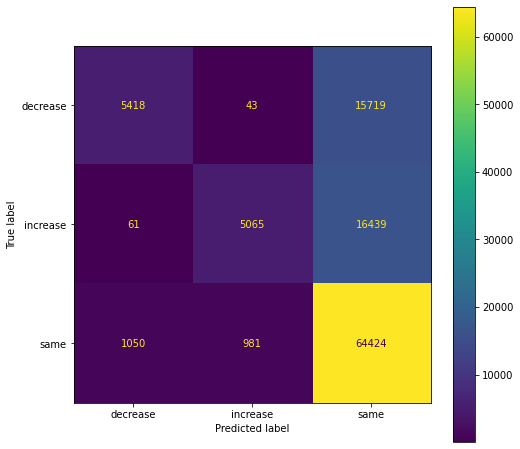

In [16]:
df1 = pd.read_csv('data/yearly_tick_data/tab_2020.csv')
#df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

model_new = load_model('data/model/model_dnn.h5')    
scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 

x_scaled = scaler_obj.transform(live_df.values)
predictions = model_new.predict(x_scaled) 
rounded_predictions = np.argmax(predictions, axis = -1)

#live_df['predictions'] = y_map[data['rounded_predictions'][0]]
live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()